# Capítulo 7. Aprendizaje en Conjunto y Random Forest

## <span style="color:green">1.Clasificador de Votaciones </span>

In [2]:
#Importa las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
#Importa los clasificadores
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
#Este no lo conocían, se los presento
#Este VotingClassifier va a recibir los modelos y va a contar los votos de los resultados
from sklearn.ensemble import VotingClassifier  

In [4]:
#Trae el set de datos
candidates = {'gmat': [780,750,690,710,680,730,690,720,740,690,610,690,710,680,770,610,580,650,540,590,620,600,550,550,570,670,660,580,650,660,640,620,660,660,680,650,670,580,590,690],
              'gpa': [4,3.9,3.3,3.7,3.9,3.7,2.3,3.3,3.3,1.7,2.7,3.7,3.7,3.3,3.3,3,2.7,3.7,2.7,2.3,3.3,2,2.3,2.7,3,3.3,3.7,2.3,3.7,3.3,3,2.7,4,3.3,3.3,2.3,2.7,3.3,1.7,3.7],
              'work_experience': [3,4,3,5,4,6,1,4,5,1,3,5,6,4,3,1,4,6,2,3,2,1,4,1,2,6,4,2,6,5,1,2,4,6,5,1,2,1,4,5],
              'admitted': [1,1,0,1,0,1,0,1,1,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,1,1,0,1,1,0,0,1,1,1,0,0,0,0,1]
              }
#Es sencillo pero, es trabajo honesto
df = pd.DataFrame(candidates,columns= ['gmat', 'gpa','work_experience','admitted'])
df.head()

,gmat,gpa,work_experience,admitted
0,780,4.0,3,1
1,750,3.9,4,1
2,690,3.3,3,0
3,710,3.7,5,1
4,680,3.9,4,0


In [5]:
#Dividir el dataframe en dos: los datos a predecir y los datos predichos
x = df[['gpa','gmat','work_experience']]
y = df['admitted']

In [6]:
#Importa el train_test_split
from sklearn.model_selection import train_test_split
#Divide los datos
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3, random_state = 42, shuffle = True)


In [7]:
#Entrena los modelos
    #Genera los objetos
svm = SVC()
    #Establece una profundidad máxima de 2 en el árbol de decisión
arbol = DecisionTreeClassifier(max_depth=2)

In [8]:
#Genera un objeto para el votingClassifier
votos = VotingClassifier(estimators=[ ("svm", svm), ("arbol", arbol)],voting="hard")
votos.fit(x_train,y_train)

VotingClassifier(estimators=[('svm', SVC()),
                             ('arbol', DecisionTreeClassifier(max_depth=2))])

En caso de querer una votación suave, poner en voting="Soft" (más adelante se ejemplifica)

In [9]:
#Calcular la exactitud de los modelos con accuracy_score
from sklearn.metrics import accuracy_score
#Ciclar a tráves de los 3 modelos que estamos desarrolando 
for i in (svm, arbol, votos):
    #Ajustar
    i.fit(x_train,y_train)
    #Predecir los datos del x_test 
    y_pred = i.predict(x_test)
    print(i.__class__.__name__,
        #Arrojar el puntaje de exactitud 
         accuracy_score(y_test,y_pred))

SVC 0.6666666666666666
DecisionTreeClassifier 0.8333333333333334
VotingClassifier 0.9166666666666666


In [10]:
#En caso de querer un margen suave se tiene que hacer ciertas modificaciones
svm = SVC(probability=True)
votos = VotingClassifier(estimators=[ ("svm", svm), ("arbol", arbol)],voting="soft")
votos.fit(x_train,y_train)
#Calcular la exactitud de los modelos con accuracy_score
from sklearn.metrics import accuracy_score
#Ciclar a tráves de los 3 modelos que estamos desarrolando 
for i in (svm, arbol, votos):
    #Ajustar
    i.fit(x_train,y_train)
    #Predecir los datos del x_test 
    y_pred = i.predict(x_test)
    print(i.__class__.__name__,
        #Arrojar el puntaje de exactitud 
         accuracy_score(y_test,y_pred))

SVC 0.6666666666666666
DecisionTreeClassifier 0.8333333333333334
VotingClassifier 0.8333333333333334


***

## <span style="color:green">2. Bagging y Pasting </span>

In [11]:
# Importar el clasificador BaggingClassifier
from sklearn.ensemble import BaggingClassifier
#Genera el objeto a raíz de un árbol de decisión (puede ser el que quieran)
bagging = BaggingClassifier(DecisionTreeClassifier(),
                           #cantidad de (en este caso) árboles de decisión 
                           n_estimators=100,
                            #La cantidad de datos que tomará de una muestra
                           max_samples=10,
                           #Bagging=True; Pasting=False
                           bootstrap=True)
bagging.fit(x_train,y_train)
y_pred = bagging.predict(x_test)
#Aunque dará un puntaje similar al clasificador de votaciones, esto se debe al set de datos pequeño.
accuracy_score(y_test,y_pred)

0.9166666666666666

In [12]:
#Hacer el ejemplo con pasting pero utilizar ahora SVC
from sklearn.ensemble import BaggingClassifier
pasting = BaggingClassifier(SVC(),
                           n_estimators=50,
                           max_samples=15,
                           bootstrap=False)
pasting.fit(x_train,y_train)
y_pred = pasting.predict(x_test)
accuracy_score(y_test,y_pred)

0.3333333333333333

Pasting no suele ser utilizado en ejemplos reales. El puntaje de exactitud evidencia que es un pésimo modelo 

***

### <span style="color:blue">2.1 Evaluación Out-of-Bag  </span>

In [13]:
#Importar BaggingClassifier
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=100,
                           max_samples=10,
                            #Poner oob_score=True para poder hacer la evaluación
                           bootstrap=True, oob_score=True)
#Ajustar
bagging.fit(x_train,y_train)
#Visualiza el puntaje OOB
bagging.oob_score_

0.8571428571428571

Este puntaje es un parámetro extra, puedes concluir si hay o no un ajuste con base a los parámetros que ya sacaste y el puntaje OOB.

***

## <span style="color:green">3. Random Subspace </span>

In [14]:
#Hacer un Bagging como los anteriores
bagging = BaggingClassifier(DecisionTreeClassifier(),
                           n_estimators=100,
                           max_samples=10,
                           bootstrap=True,
                            #Max_features le dice que solo tomará 2 variables
                           max_features=2,
                           oob_score=True)
#Ajustar
bagging.fit(x_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_features=2,
                  max_samples=10, n_estimators=100, oob_score=True)

In [15]:
#Visualizar el puntaje de exactitud
bagging.fit(x_train,y_train)
y_pred=bagging.predict(x_test)
accuracy_score(y_test,y_pred)

0.9166666666666666

## <span style="color:green">4. Random Forest </span>

In [16]:
#Importar RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
#Hacer RandomForestClassifier, establecer los parámetros similares al bagging
rf = RandomForestClassifier(n_estimators=100,
                           max_leaf_nodes=4,
                           max_features=2)

In [17]:
#Hacer el ajuste
rf.fit(x_train, y_train)

RandomForestClassifier(max_features=2, max_leaf_nodes=4)

In [18]:
#Hacer las predicciones
y_pred=rf.predict(x_test)

In [19]:
#Visualiza el puntaje 
accuracy_score(y_test,y_pred)

0.9166666666666666

En el futuro, no les pedirán bagging, se prefiere utilizar Random Forest

### <span style="color:blue">4.1 Predictores </span>

In [20]:
#Realiza el árbol de manera aleatoria
random = RandomForestClassifier(n_estimators=100)
#Despliega los parámetros importantes o predictores
random.fit(x_train,y_train)
for nombre, score in zip(x.columns, random.feature_importances_):
    print(nombre,score)

gpa 0.3900977179067117
gmat 0.3461470919694333
work_experience 0.263755190123855


El valor que arroja en cada variable es equivalente al nivel de importancia de la misma. En este caso el **gpa** es la variable que tiene mayor peso en la decisión

## <span style="color:green">5. Boosting </span>

### <span style="color:blue">5.1 Adaboost </span>

In [21]:
#Importar AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
#Crear objeto de Adaboost con árboles de decisiones  
ada = AdaBoostClassifier(DecisionTreeClassifier(),
                         n_estimators=100,
                         learning_rate=0.1)
ada.fit(x_train,y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(), learning_rate=0.1,
                   n_estimators=100)

In [22]:
#Calcular el puntaje de exactitud para adaboost
y_pred=ada.predict(x_test)
accuracy_score(y_test,y_pred)

0.9166666666666666

### <span style="color:blue">5.2 Boosting con Gradiente </span>

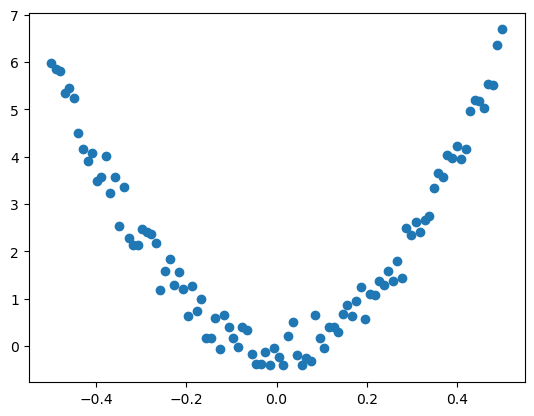

In [23]:
#Crear un set de datos, especificamente una parábola para una mejor visualización 
m = 100
x = np.linspace(-0.5,0.5,m)
y = 25*x**2 + np.random.random(m) -0.5
plt.scatter(x,y)

In [24]:
#Crear el primer predictor, utiliza árboles de decisiones y regularizalo con un max_depth=2
from sklearn.tree import DecisionTreeRegressor
x = x.reshape(-1,1)
arbol1 = DecisionTreeRegressor(max_depth=2)
arbol1.fit(x,y)

DecisionTreeRegressor(max_depth=2)

In [25]:
#Calcular los errores residuales que 
#son la diferencia entre las predicciones del modelo y el valor de la variable a predecir
y2 = y - arbol1.predict(x)

In [26]:
#crear el segundo predictor en base a esos residuales.
arbol2 = DecisionTreeRegressor(max_depth=2)
arbol2.fit(x,y2)

DecisionTreeRegressor(max_depth=2)

In [27]:
#Visualizar que sucede si sumamos las predicciones del primer predictor con el segundo
y_pred = sum(arbol.predict(x) for arbol in (arbol1, arbol2))

In [28]:
#Repetir el mismo procedimiento para crear el árbol 3.
y3 = y - arbol2.predict(x)
arbol3 = DecisionTreeRegressor(max_depth=2)
arbol3.fit(x,y3)

DecisionTreeRegressor(max_depth=2)

In [29]:
#Ahora vamos a ver que sucede si sumamos los 3 árboles
y_pred = sum(arbol.predict(x) for arbol in (arbol1, arbol2, arbol3))

In [30]:
#Crear exactamente el mismo modelo que creamos antes
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2, 
                                n_estimators=3, 
                                learning_rate=1.0)
gbrt.fit(x,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

In [31]:
#En este caso utilizaremos el error medio cuadrado.
from sklearn.metrics import mean_squared_error
x_train, x_test, y_train, y_test = train_test_split(x,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(x_train, y_train)

errores = [mean_squared_error(y_test,y_pred) for y_pred in gbrt.staged_predict(x_test)]
mejor = np.argmin(errores)
mejor

np.int64(44)

En este caso el mejor caso es en **56** de los 120 árboles que probamos por lo que deberíamos crear nuestro modelo con 56 árboles de decisión.

In [32]:
# Para que funcione instala xgboost
#!pip install xgboost

#Evaluar el early stopping automáticamente con XGBRegressor
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

xgboost, es una biblioteca de aprendizaje automático muy popular y eficiente que implementa el algoritmo de "gradient boosting" para árboles de decisión.

In [37]:
# Se crea un modelo de regresión XGBoost con early_stopping_rounds=1
xgb = XGBRegressor(early_stopping_rounds=1)

# Se entrena el modelo con los datos de entrenamiento (x_train, y_train)
xgb.fit(x_train, y_train, 
       eval_set=[(x_test, y_test)],  # Se usa el conjunto de prueba para evaluar el rendimiento durante el entrenamiento
       verbose=False)  # Se desactivan los mensajes de progreso durante el entrenamiento

# Se utiliza el modelo entrenado para hacer predicciones sobre el conjunto de prueba
y_pred = xgb.predict(x_test)

## <span style="color:green">6. Stacking </span>

In [38]:
#Importa los regresores necesarios StackingRegressor,LinearRegression, RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

#Generar el árbol de decisión
arbol = DecisionTreeRegressor(max_depth=20)
#Generar la regresión lineal
lineal = LinearRegression()
#Generar el bosque aleatorio
random = RandomForestRegressor()
#Genera los tres modelos 
stacking = StackingRegressor(estimators=[("arbol", arbol),
                            ("lineal", lineal),
                          ("random", random)])
#Utiliza Stacking
stacking.fit(x,y)

StackingRegressor(estimators=[('arbol', DecisionTreeRegressor(max_depth=20)),
                              ('lineal', LinearRegression()),
                              ('random', RandomForestRegressor())])